In [5]:
using Distributed

In [6]:
workers()

1-element Vector{Int64}:
 1

In [7]:
addprocs(30)
;

In [8]:
nworkers()

30

In [9]:
@everywhere using FastaIO
@everywhere using MultivariateStats
@everywhere using LinearAlgebra
@everywhere using DelimitedFiles
@everywhere using StatsBase
@everywhere using DCAUtils
@everywhere using Plots
@everywhere using Random
@everywhere using Printf
@everywhere using LinearAlgebra
@everywhere using GLM
@everywhere using Statistics
@everywhere using KitMSA
using Tullio, JLD2

In [10]:
@everywhere include("../src/read_write.jl")
@everywhere include("../src/energy.jl")
@everywhere include("../src/msa_tools.jl")
@everywhere include("../src/extra_tools.jl")

In [11]:


function amino_seq2dna_seq(seq)
    seq_dna=[]
    for a in seq
        push!(seq_dna, sample(amino2cod[a]))
    end
    return seq_dna
end

function dna_seq2amino_seq(seq_dna)
    new = []
    for a in seq_dna
        push!(new, cod2amino[a])
    end
    return new
end

function pairwise_hamming(msa::Array{Int8,2})
    num_seqs = size(msa, 1)
    pairwise_distances = Array{Int,1}(undef, num_seqs*(num_seqs-1)÷2)
    idx = 1
    for i in 1:num_seqs-1
        for j in i+1:num_seqs
            dist = KitMSA.my_hamming(msa[i,:], msa[j,:])
            pairwise_distances[idx] = dist
            idx += 1
        end
    end
    return pairwise_distances
end


function eliminate(msa, tresh, idx)
    L = length(msa[idx,:])
    trimmed_msa = []
    for i in 1:length(msa[:,1])
        d = KitMSA.my_hamming(msa[idx,:], msa[i,:])
        if  d > L*tresh
            push!(trimmed_msa, msa[i,:])
        end
    end
    push!(trimmed_msa, msa[idx,:])
    return hcat(trimmed_msa...)'
end


function reweighting(msa, tresh)
    final_msa =[]
    new_msa = deepcopy(msa)
    a = 0
    for i in 1:20000
        new_msa = eliminate(new_msa, tresh, 1)
    end    
    println(length(new_msa[:,1]))
    return new_msa
end

function project_pca(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, label= label1, legend=:topright)
    scatter!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    savefig(filename)
end

function plot_pca(pc_ref, eigenv, matrices, filepath)
    
    for i in 1:length(matrices)
        one_hot_proj = one_hot(matrices[i])
        project_pca(joinpath(filepath, "pca$(i).png"), "nat", "sil step $(i)", eigenv, pc_ref, one_hot_proj)
        println(i)
    end
end

plot_pca (generic function with 1 method)

In [12]:
@everywhere function Delta_energy(h::Array{Float64,2}, J::Array{Float64,4}, 
        S::Array{<:Integer,1}, ref::Array{<:Integer, 1})
    q, N = size(h)
    E = 0.0
    
    index_v = collect(1:N)
    common = (S .== ref)
    idx = findfirst(isequal(false), common)
    common = index_v[common]
    #println(idx)
    #println(common)
    E -= (h[S[idx],idx] - h[ref[idx],idx])
    @fastmath for j = 1:N
        if j > idx
            @inbounds  E -= (J[S[j],S[idx],j,idx] - J[ref[j],ref[idx],j,idx] )
        end
    end
    
    @fastmath for i in common
        if idx > i
            @inbounds  E -= (J[S[idx],S[i],idx,i] - J[ref[idx],ref[i],idx,i] )
        end
    end
    
    return E
end


In [13]:
@everywhere function get_accessible_nucleo_muts_metro_DNA_det_bal(old_cod)
    if old_cod .== "---"
        amino_list = [i for i in 1:21]
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        codon_list = filter!(aa->aa != old_cod, codon_list)
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    end
    
    old_codon = [string(old_cod[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 12)
    
    for i in 1:3
        new_codon = deepcopy(old_codon)
        for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
            new_codon[i] = nucl
            codon_list[(i-1)*4 + j] = join(new_codon)
        end
    end
    
    push!(codon_list, "---")
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	amino_list = unique!(filter!(aa->aa != 21, amino_list))

    #codon_list = filter!(aa->aa != "TAA", codon_list)
    #codon_list = filter!(aa->aa != "TAG", codon_list)
    #codon_list = filter!(aa->aa != "TGA", codon_list)
    codon_list = filter!(aa->aa != old_cod, codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end


@everywhere function get_accessible_nucleo_for_del_ins(old_cod)

    if old_cod .== "---"
        amino_list = [i for i in 0:20]
        amino_list[1] = 21
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        #push!(codon_list, old_cod )
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    else
        codon_list = ["---"]
        push!(codon_list, old_cod)
        amino_list = get.(Ref(cod2amino), codon_list, 0)
        #println(amino_list)
        return amino_list, codon_list
    end
end
   

In [14]:
@everywhere mutable struct SeqToEvolve
    Amino   :: Array{Int64}
    DNA :: Array{AbstractString}
end

@everywhere function get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos::Integer)
    old_codon = [string(old_codon[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 4)
	new_codon = deepcopy(old_codon)
	for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
		new_codon[nucleo_pos] = nucl
		codon_list[j] = join(new_codon)
	end
    
    codon_list = filter!(aa->aa != "TAA", codon_list)
    codon_list = filter!(aa->aa != "TAG", codon_list)
    codon_list = filter!(aa->aa != "TGA", codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end

@everywhere function sum_couplings_inbounds(mutated_seq, q_k, k, J::Array{Float64,4}, N)
    result = 0
    @inbounds for i in 1:N
        aa = mutated_seq[i]
        cc = J[mutated_seq[i], q_k ,i, k]
        #println("aa: $(aa) $(q_k), Site $(i) $(k)")
        #println("Coupling: $(result)")
        result += J[mutated_seq[i], q_k ,i, k]
        #println("Res: $(result)")
    end
    
    return result
end 

@everywhere function nucleo_cond_proba_DNA_gibbs(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
   
	@inbounds for (index, codon_k) in enumerate(codon_list)
        q_k = q[index]
        log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
        log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
		prob[index] = exp(log_proba/T)
	end
	return normalize(prob,1)
end



@everywhere function log_p(mutated_seq, q_k, k, J::Array{Float64,4}, N::Integer,T=1)
    
    log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
    log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
    return log_proba  
end


@everywhere function square_array(arr)
    squares = Dict()
    result = similar(arr)
    for i in 1:length(arr)
        if haskey(squares, arr[i])
            result[i] = squares[arr[i]]
            println("not computed")
        else
            square = arr[i]^2
            squares[arr[i]] = square
            result[i] = square
            println("computed")
        end
    end
    return result
end


@everywhere function nucleo_cond_proba_DNA_gibbs_new(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
        
    d = Dict{Int64, Float64}()
    
	@inbounds for (index, q_k) in enumerate(q)
            
        if haskey(d, q_k)
            log_proba = d[q_k]
        else
            log_proba = log_p(mutated_seq, q_k, k, J, N, T)
            d[q_k] = log_proba
        end
		prob[index] = exp(log_proba/T)
	end
        
	return normalize(prob,1)
end

In [15]:
@everywhere function del_ins_codon_sampling(arr)
    n = length(arr)
    beta = 1/64
    alpha = 1-64*beta
    gamma = 1-beta
    if n==2
        probabilities = [beta, gamma]
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    else 
        probabilities = fill(beta, n)
        probabilities[1] = alpha
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    end
end
    

    
@everywhere function gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T)
    pos_mut = rand(non_gapped_pos)

	old_codon = mutated_seq.DNA[pos_mut]
        
    nucleo_pos = rand(1:3)
        
    amino_list, codon_list = get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos)
    
    if length(unique(amino_list)) == 1
        new_codon = rand(codon_list)
    else
        #println(nucleo_cond_proba_DNA_gibbs_new(pos_mut, amino_list, codon_list, mutated_seq.Amino, h, J, N, T))
        new_codon = sample(codon_list, ProbabilityWeights(nucleo_cond_proba_DNA_gibbs_new(pos_mut, amino_list, codon_list, mutated_seq.Amino, h, J, N, T)))
    end
            
    aa = cod2amino[new_codon]
        
	mutated_seq.DNA[pos_mut] = new_codon	
	mutated_seq.Amino[pos_mut] = aa
    
    return mutated_seq
end     


@everywhere function metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
    
        
    pos_mut = rand(1:length(mutated_seq.Amino))

	old_codon = mutated_seq.DNA[pos_mut]
    old_amino = mutated_seq.Amino[pos_mut]
    amino_list, codon_list = get_accessible_nucleo_for_del_ins(old_codon)
    new_codon = del_ins_codon_sampling(codon_list)
    
    if new_codon == "TAA"  ||  new_codon == "TAG"   || new_codon == "TGA"  || new_codon == old_codon
        
    else
        new_amino = cod2amino[new_codon]  
        new_sequence = deepcopy(mutated_seq.Amino)
        new_sequence[pos_mut] = new_amino
        deltaE = Delta_energy(h, J, new_sequence, mutated_seq.Amino)
        accept_proba = (length(amino2cod[old_amino])/length(amino2cod[new_amino]))*exp(-(1/T)*deltaE)
        if rand() < accept_proba
            aa = cod2amino[new_codon]
            mutated_seq.DNA[pos_mut] = new_codon	
            mutated_seq.Amino[pos_mut] = aa
        end
    end
    return mutated_seq
end


@everywhere function parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, dir_amino::AbstractString, dir_dna::AbstractString, 
                        sampler_type::AbstractString, wt_name::AbstractString, ref_seq, MC_steps::Integer, h::Array{Float64,2}, 
                        J::Array{Float64,4}, N::Integer, chain_num::Integer, each_step,T = 1)
    #log_steps = round.(Int, [n^(3.8) for n in 1:450])
    
    file_path_amino = joinpath(dir_amino, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
    file_path_dna = joinpath(dir_dna, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
            
    
    mutated_seq = deepcopy(ref_seq[chain_num])
    if chain_num %40000 == 0
        println("p = $(p)")
    end
    
    FastaWriter(file_path_amino, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
    end
    
    FastaWriter(file_path_dna, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", join(mutated_seq.DNA))   
    end     
    @inbounds for steps in 1: MC_steps
        non_gapped_pos = [pos for (pos, amino) in enumerate(mutated_seq.Amino) if amino != 21]
        if rand()<(1-p)
            mutated_seq = gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T)
        else
            mutated_seq = metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
        end  
        
        if steps % each_step == 0
            FastaWriter(file_path_amino, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
            end
            
            FastaWriter(file_path_dna, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", join(mutated_seq.DNA))   
            end
        end 
	end
                    
end

In [16]:
@everywhere function sample_codons(arr)
    n = length(arr)
    probabilities = fill(7/64, n)
    probabilities[end] = 1/64
    index = sample(1:n, Weights(probabilities))
    return arr[index]
end

#arr = [1, 2, 3, 4,5,6,7,8,9,10]

#sampled_elements = [sample_codons(arr) for i in 1:640000]

#histogram(sampled_elements, bins = 10)


In [17]:
@everywhere function parallel_evol_seq_fix_steps_DNA_metropolis_nucleo(dir_amino::AbstractString, 
        dir_dna::AbstractString, sampler_type::AbstractString, wt_name::AbstractString, ref_seq, 
        MC_steps::Integer, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer, chain_num::Integer, T = 1)
    #log_steps = round.(Int, [n^(3.8) for n in 1:450])
    log_steps = [1000*i for i in 1:1000]
    
    
    file_path_amino = joinpath(dir_amino, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
    file_path_dna = joinpath(dir_dna, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
            
    mutated_seq = deepcopy(ref_seq[chain_num])
    sites = 1:length(mutated_seq.Amino)
    
    FastaWriter(file_path_amino, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
    end
    
    FastaWriter(file_path_dna, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", join(mutated_seq.DNA))   
    end
	
    @inbounds for steps in 1: MC_steps
        
        pos_mut = rand(1:length(mutated_seq.Amino))

		old_codon = mutated_seq.DNA[pos_mut]
        old_amino = mutated_seq.Amino[pos_mut]
              
        amino_list, codon_list = get_accessible_nucleo_muts_metro_DNA_det_bal(old_codon)
        
        if old_codon == "---"
            new_codon = rand(codon_list)
        else
            new_codon = sample_codons(codon_list)
        end   
        
        if new_codon == "TAA"  ||  new_codon == "TAG"   || new_codon == "TGA"
            
            #println("There is a stop codon")
        #elseif new_codon == "---"
            
        elseif cod2amino[new_codon] == old_amino
            new_amino = cod2amino[new_codon]
            mutated_seq.DNA[pos_mut] = new_codon	
            mutated_seq.Amino[pos_mut] = new_amino
        else
            new_amino = cod2amino[new_codon]  
            new_sequence = deepcopy(mutated_seq.Amino)
            new_sequence[pos_mut] = new_amino
            deltaE = Delta_energy(h, J, new_sequence, mutated_seq.Amino)
            accept_proba = (length(amino2cod[old_amino])/length(amino2cod[new_amino]))*exp(-(1/T)*deltaE)
            if rand() < accept_proba
                aa = cod2amino[new_codon]
                mutated_seq.DNA[pos_mut] = new_codon	
                mutated_seq.Amino[pos_mut] = aa
            end
        end
        
        if steps in log_steps
            println(steps)
            FastaWriter(file_path_amino, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
            end
            
            FastaWriter(file_path_dna, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", join(mutated_seq.DNA))   
            end
        end 
	end
end

In [139]:
@load "../../DataAttentionDCA/data/PF00014/full_ortfalse_parsH256η0.5λ0.01T250.jld2"
@tullio J[a, b, i, j] := m.K[i,h] * m.K[j,h] * m.V[a,h] * m.V[b,h] * (i != j)
J = Float64.(J)
J =  0.5 * (J + permutedims(J,[2,1,4,3]))
h = Float64.(m.h)#zeros(size(m.V, 1), size(m.K,1))
;

In [20]:
using DCAUtils

In [21]:
Z = Int8.(fasta2matrix("../../DataAttentionDCA/data/PF00014/PF00014_mgap6.fasta.gz"))
#f = compute_weighted_frequencies(Z, 0.2)[1]
;

In [76]:
println(Z[1,:])

Int8[21, 2, 10, 3, 4, 10, 7, 13, 6, 15, 2, 16, 12, 20, 18, 4, 15, 19, 20, 20, 3, 15, 6, 17, 9, 9, 2, 15, 16, 5, 14, 20, 6, 6, 2, 6, 6, 12, 15, 12, 7, 5, 20, 16, 9, 4, 12, 2, 8, 5, 7, 2, 21]


## Parallel Run

In [140]:

steps = 50000
each_step = 100
T = 1.0 
sampler_type = "mixed"
nseq = 1:700
wt_name = "PF00014"
N = size(h,1)

#start_wt = [21, 2, 10, 3, 4, 10, 7, 13, 6, 15, 2, 16, 12, 20, 18, 4, 15, 19, 20, 20, 3, 15, 6, 17, 9, 9, 2, 15, 16, 5, 14, 20, 6, 6, 2, 6, 6, 12, 15, 12, 7, 5, 20, 16, 9, 4, 12, 2, 8, 5, 7, 2, 21]
seed_seq = [SeqToEvolve(Z[1,:] , amino_seq2dna_seq(Z[1,:])) 
   for i in 1:nseq[end]] #beta
p=0.5
;

In [141]:
dir_amino = "../../scra_data_beta/amino_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
dir_dna = "../../scra_data_beta/dna_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
mkdir(dir_amino)
mkdir(dir_dna)

"../../scra_data_beta/dna_mixed_PF00014_steps50000_seqs700_T1.0p0.5"

In [142]:
@everywhere function parallelo_evol_run(i) 
    if sampler_type == "mixed"
        parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, dir_amino, dir_dna, 
            sampler_type, wt_name, seed_seq, steps, h, J, N, i, each_step, T)
        if i%10 == 0
            println(i)
        end
    else
        throw(ArgumentError("Invalid sampler type: $sampler_type"))
    end
end

In [143]:
for ww in workers()
    fetch(@spawnat ww p, each_step, dir_amino, dir_dna, sampler_type, 
        wt_name, seed_seq, steps, h, J, T, amino2cod, cod2amino, N)
    #println("fetched")
end
;

In [81]:
for ww in workers()
    fetch(@spawnat ww p, each_step, dir_amino, dir_dna, sampler_type, T, N, seed_seq, steps)
    #println("fetched")
end
;


In [144]:
start=time()
pmap(parallelo_evol_run, nseq)
fine=time()
println(fine-start)
println("MSAs GENERATED!!")

      From worker 10:	10
      From worker 21:	30
      From worker 26:	20
      From worker 24:	40
      From worker 12:	50
      From worker 16:	60
      From worker 15:	70
      From worker 4:	80
      From worker 13:	90
      From worker 19:	100
      From worker 28:	110
      From worker 26:	120
      From worker 3:	130
      From worker 28:	140
      From worker 8:	150
      From worker 3:	160
      From worker 6:	170
      From worker 4:	180
      From worker 30:	190
      From worker 12:	200
      From worker 7:	210
      From worker 11:	220
      From worker 27:	230
      From worker 18:	240
      From worker 11:	250
      From worker 6:	260
      From worker 18:	270
      From worker 13:	280
      From worker 12:	290
      From worker 26:	300
      From worker 21:	310
      From worker 27:	320
      From worker 30:	330
      From worker 10:	340
      From worker 8:	350
      From worker 9:	360
      From worker 15:	370
      From worker 19:	380
      From worker 23:	390
     

In [145]:
folder_path = "../../scra_data_beta/amino_mixed_PF0014_steps50000_seqs100_T1.0p0.0/"
folder_path = "../../scra_data_beta/amino_mixed_PF0014_steps50000_seqs1000_T1.0p0.5/"
folder_path = "../../scra_data_beta/amino_mixed_PF00014_steps50000_seqs700_T1.0p0.5/"
fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files]
step_matrices = build_seq_matrices(matrices)
;

  0.682413 seconds (2.19 M allocations: 262.145 MiB, 9.53% compilation time)


In [146]:
f_sil = [compute_weighted_frequencies(Int8.(m'),0)[1] for m in step_matrices];
f = compute_weighted_frequencies(Int8.(Z[1:1000, :]'),0.2)[1]
f2 = compute_weighted_frequencies(Int8.(Z[1000:2000, :]'),0.2)[1]
;

θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 53 Meff = 700


In [147]:
println(corspearman(f, f2))
mean(count_muts_msa(Z, matrices[1][1,:]))

0.9739468940820393


32.09838235294118

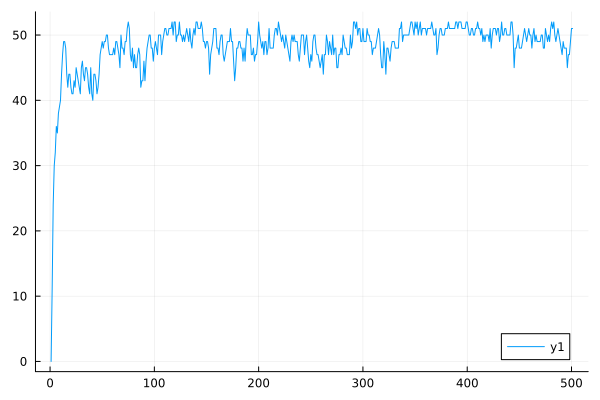

In [148]:
plot(count_muts_msa(matrices[1], matrices[1][1,:]))

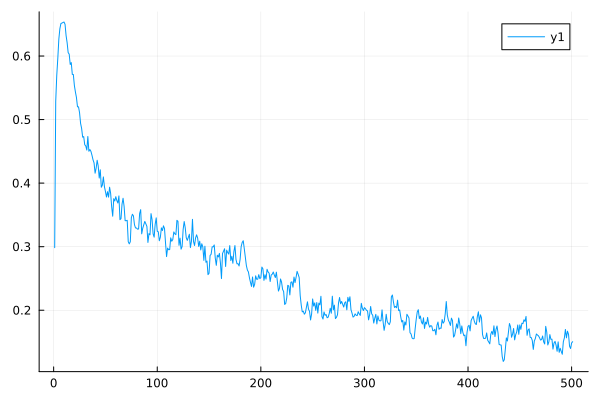

In [149]:
plot([corspearman(f, ff) for ff in f_sil])